# Looking into cross-correlation  
#### Joshua Poirier, [NEOS](http://www.neosgeo.com)  
2016 SEG Machine Learning Contest  

## 1 Introduction  

The purpose of this notebook is to examine the strength of cross-correlation between wells for the different features in our data set.  The idea is that we may be able to replace the **RELPOS** relative position feature with something more geologically (and predictively) meaningful.  The strata may be dipping, so a horizon (and thereby subsequent facies) may occur in the upper half in some wells but the lower half in others.  Let's demonstrate this with a simple synthetic example.  

In [7]:
# visualization packages
library(repr)
library(ggplot2)
library(ggthemes)
library(cowplot)

## 2 Synthetic example  

Let's create a synthetic binary log for four wells.  Each show a 20 foot anomalous section offset from each other.

In [17]:
# initialize with zero values
df <- data.frame(depth=rep(0,60),
                 a=rep(0,60), 
                 b=rep(0,60), 
                 c=rep(0,60), 
                 d=rep(0,60))

# insert 20 foot sections of anomalous values
df$depth <- 1:60
df$a[10:30] <- 1
df$b[30:50] <- 1 # offset 20 feet below A
df$c[0:20] <- 1 # offset 10 feet above A
df$d[20:40] <- 1 # offset 10 feet below A

# add random noise
set.seed(3124)
df$a <- df$a + rnorm(60,0,.25)
df$b <- df$b + rnorm(60,0,.25)
df$c <- df$c + rnorm(60,0,.25)
df$d <- df$d + rnorm(60,0,.25)

head(round(df,2))

depth,a,b,c,d
1,-0.33,0.20,0.89,0.32
2,-0.47,0.14,0.85,0.32
3,0.37,-0.04,1.33,0.17
4,0.46,0.32,1.61,-0.02
5,0.08,0.01,1.34,0.06
6,0.02,-0.26,0.53,0.10


Now let's plot these wells.

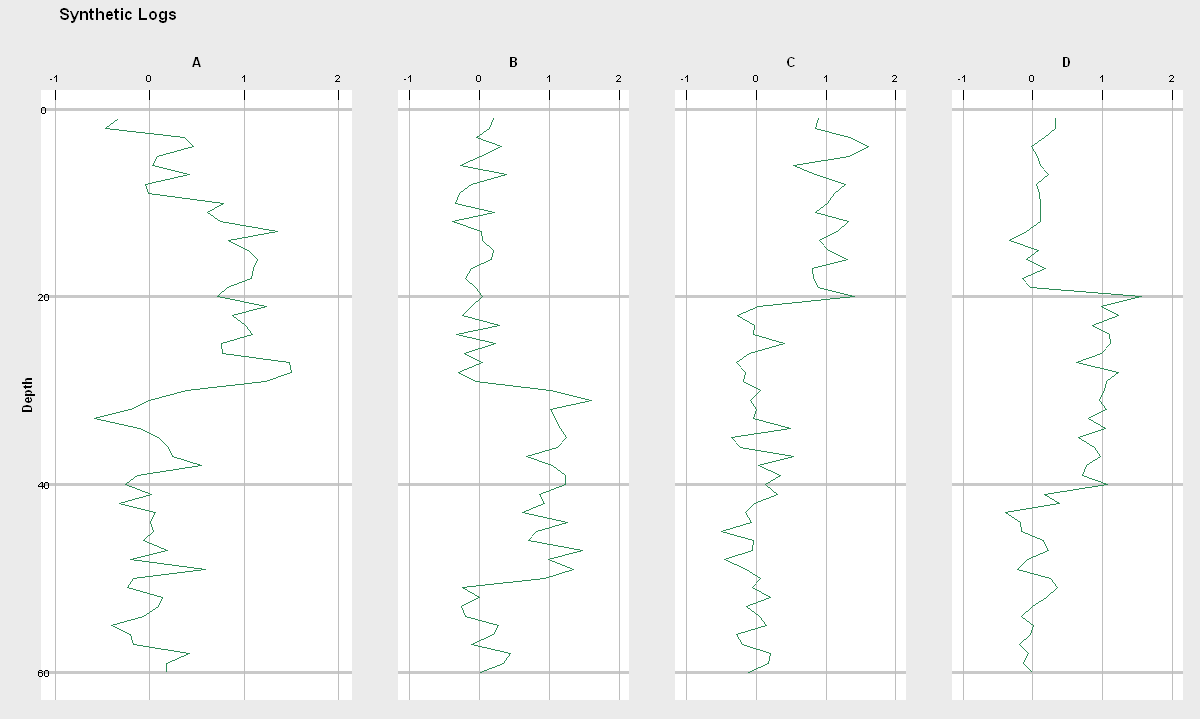

In [20]:
# basic plotting function
plotLog <- function(x, title, isA=F) {
    names(x) <- c("Depth", "Log")
    g <- ggplot(x) + theme_economist_white(gray_bg=T) +
        scale_y_continuous(lim=c(-1,2)) + 
        scale_x_continuous(trans="reverse") + coord_flip() + labs(title="", x="", y=title) +
        geom_line(aes(x=Depth, y=Log), lwd=.5, col="seagreen4") +
        theme(panel.grid.major.x = element_line(colour="gray", size=0.25), legend.position="none", 
              axis.text=element_text(size=6), axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank())
    if (isA) {g <- g + labs(x="Depth") + theme(axis.text.y=element_text(size=6))}
    g <- switch_axis_position(g, 'x')
    g
}

# build tracks
g1 <- plotLog(df[,c(1,2)], "A", isA=T)
g2 <- plotLog(df[,c(1,3)], "B")
g3 <- plotLog(df[,c(1,4)], "C")
g4 <- plotLog(df[,c(1,5)], "D")

# plot all four tracks!
options(repr.plot.width=10, repr.plot.height=6)
g <- plot_grid(g1, g2, g3, g4, ncol=4, rel_widths=c(4,3,3,3))
ggdraw() + draw_plot(g, width=1, height=1) + draw_plot_label("Synthetic Logs", size=10)

If you look closely, we can qualitatively see there is a positive anomaly (centered around 1) in each of the wells.  Can we use **cross-correlation** to quantify how offset each of these wells are from each other?  Let's try!  We'll use well **A** as our reference well (i.e. what is the cross-correlation of wells **B**, **C**, and **D** with respect to well **A**.

In [60]:
# calculate cross-correlations (as a function of lag)
a_ccf <- ccf(df$a, df$a, lag.max=25, plot=F)
b_ccf <- ccf(df$a, df$b, lag.max=25, plot=F)
c_ccf <- ccf(df$a, df$c, lag.max=25, plot=F)
d_ccf <- ccf(df$a, df$d, lag.max=25, plot=F)

# place cross-correlations (as a function of lag) into data frame
df_ccf <- data.frame(lag=b_ccf[["lag"]][,,1], 
                     a_ccf=a_ccf[["acf"]][,,1],
                     b_ccf=b_ccf[["acf"]][,,1], 
                     c_ccf=c_ccf[["acf"]][,,1],
                     d_lag=d_ccf[["acf"]][,,1])

Ok so let's plot these results now!

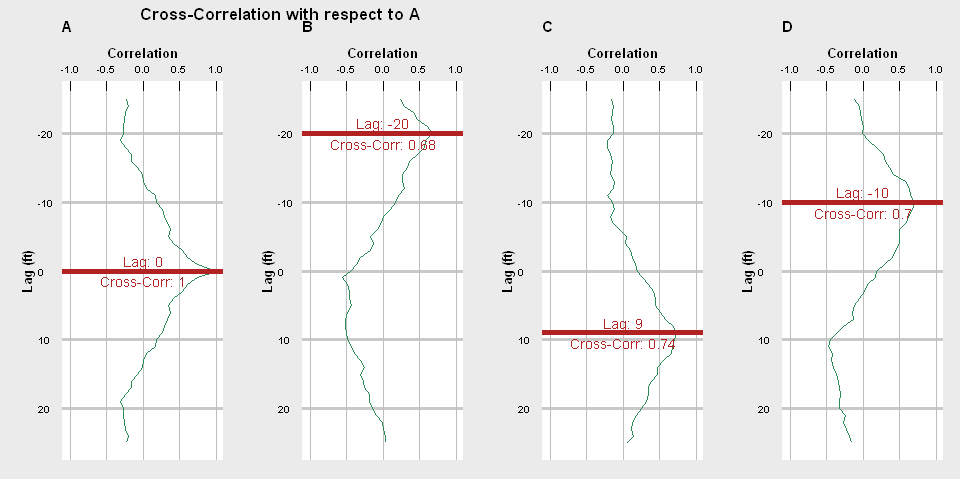

In [67]:
# function to plot cross-correlation with respect to lag
plot_ccf <- function(x, title) {
    names(x) <- c("lag", "acf")
    g <- ggplot(x) + theme_economist_white(gray_bg=T) +
        scale_y_continuous(lim=c(-1,1)) + 
        scale_x_continuous(trans="reverse") + coord_flip() + 
        labs(title=title, x="Lag (ft)", y="Correlation") +
        geom_line(aes(x=lag, y=acf), lwd=.5, col="seagreen4") +
        geom_vline(xintercept=x$lag[which.max(x$acf)], col="firebrick", lwd=1.5) +
        geom_text(aes(x=x$lag[which.max(x$acf)]+1.5, y=0, 
                      label=paste("Cross-Corr:", round(max(x$acf),2))), size=3, col="firebrick") +
        geom_text(aes(x=x$lag[which.max(x$acf)]-1.5, y=0, 
                      label=paste("Lag:", x$lag[which.max(x$acf)])), size=3, col="firebrick") +
        theme(panel.grid.major.x = element_line(colour="gray", size=0.25), legend.position="none", 
              axis.text=element_text(size=6), axis.title=element_text(size=8,face="bold"),
              title=element_text(size=6))
    g <- switch_axis_position(g, 'x')
    g
}

# build tracks for cross-correlation of B, C, and D with respect to A
g1 <- plot_ccf(df_ccf[,c(1,2)], "A")
g2 <- plot_ccf(df_ccf[,c(1,3)], "B")
g3 <- plot_ccf(df_ccf[,c(1,4)], "C")
g4 <- plot_ccf(df_ccf[,c(1,5)], "D")

# bring them all together and output 3-track plot
options(repr.plot.width=8, repr.plot.height=4)
g <- plot_grid(g1, g2, g3, g4, ncol=4)
ggdraw() + draw_plot(g, width=1, height=1) + draw_plot_label("Cross-Correlation with respect to A", size=10)

Not surprisingly, **A**'s autocorrelation (with itself) maximizes at zero-lag with a correlation of 1!  Also, even with noise added to the data, the cross-correlation determines the lag/offset of wells **B**, **C**, and **D** quite accurately.  **C** is the only well off at all - and it's off by only 1 foot, not bad!